# Baseline - xgboost

We create a simple baseline where we just throw all columns at xgboost model to see how well we can estimate emissions an how can we improve

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

id_columns = "ID_LAT_LON_YEAR_WEEK"
RANDOM_SEED = 128

# drop id_columns
df_train.drop(id_columns, axis=1, inplace=True)
target = 'emission'
features = list(df_train.columns)
features.remove(target)
assert target not in features

df_train.head(10)

# Emissions distribution

In [ ]:
# plot histogram of emission values
emission_data = df_train.copy()

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Histogram of Emission Values')
ax.set_xlabel('Emission Value')
ax.set_ylabel('Frequency')
ax.hist(emission_data['emission'], bins=100)
plt.show()

In [ ]:
# observations of emission values more than 1000

more_than_1000 = emission_data[emission_data['emission'] > 1000]
len(more_than_1000)

In [ ]:
# 50th percentile

median = emission_data['emission'].median()
print(median)

In [ ]:
# does each location have the same number of observations? 

number_of_observations = emission_data.groupby(['latitude', 'longitude']).size().reset_index(name='counts')
number_of_observations.sort_values(by='counts', ascending=False).head(10)

In [ ]:
number_of_observations = emission_data.groupby(['latitude', 'longitude']).mean().reset_index()

# plot latitude, longitude vs. mean of emission

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12, 10))

sc = ax.scatter(number_of_observations['longitude'], number_of_observations['latitude'], c=number_of_observations['emission'], alpha=0.5, cmap='magma')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Mean emission by location')
fig.colorbar(sc, ax=ax)

plt.show()

In [108]:
from datetime import datetime

# week date - create a new column from year and week_no columns. It will be a datetime
emission_data['week_date'] = emission_data.apply(lambda x: datetime.strptime(f'{int(x.year)} {int(x.week_no)} {1}', '%Y %W %w'), axis=1)
emission_data['week_date']

0       2018-12-31
1       2019-01-07
2       2019-01-14
3       2019-01-21
4       2019-01-28
           ...    
79018   2021-11-29
79019   2021-12-06
79020   2021-12-13
79021   2021-12-20
79022   2021-12-27
Name: week_date, Length: 79023, dtype: datetime64[ns]

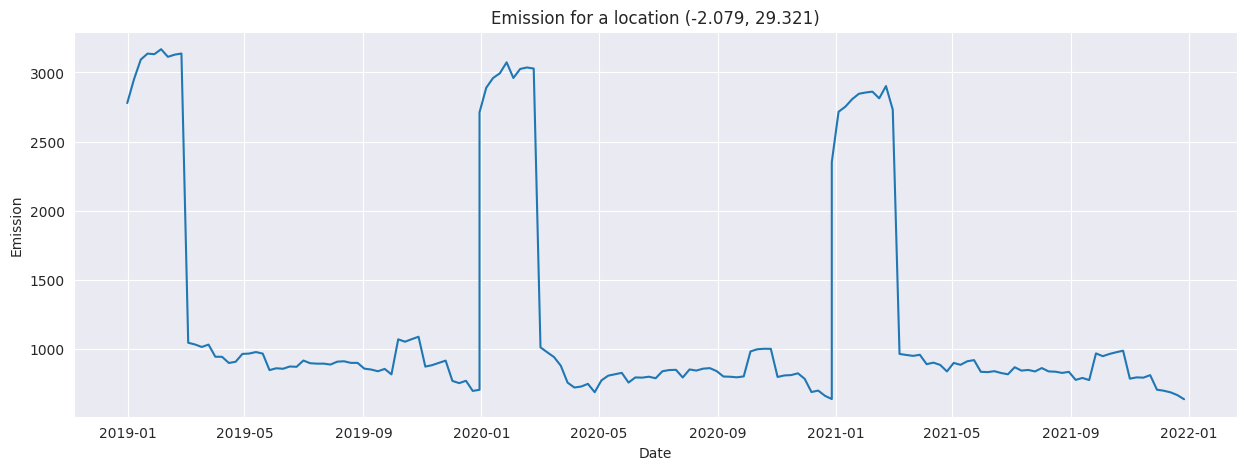

In [109]:
# let's take a look at a single location

data = emission_data[ emission_data['emission'] > 2000]
latitude, longitude = data['latitude'], data['longitude']

plot_data = emission_data[
    (emission_data['latitude'] == latitude.iloc[0]) &
    (emission_data['longitude'] == longitude.iloc[0]) 
]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(plot_data['week_date'], plot_data['emission'], label='emission')

ax.set_title('Emission for a location ({}, {})'.format(latitude.iloc[0], longitude.iloc[0]))
ax.set_xlabel('Date')
ax.set_ylabel('Emission')
plt.show()

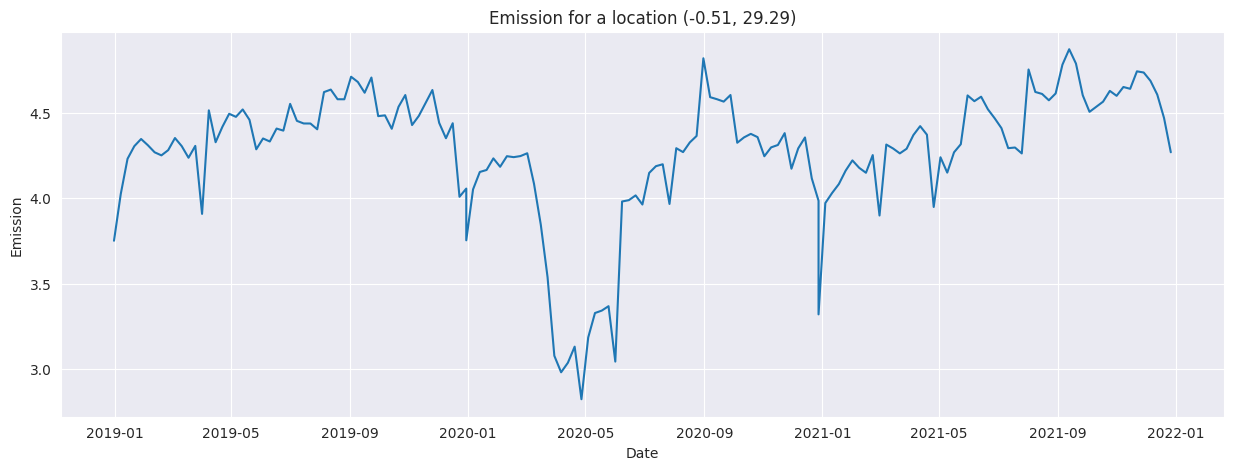

In [110]:
# let's take a look at a single location

data = emission_data[ emission_data['emission'] < 1000]
latitude, longitude = data['latitude'], data['longitude']

plot_data = emission_data[
    (emission_data['latitude'] == latitude.iloc[0]) &
    (emission_data['longitude'] == longitude.iloc[0]) 
]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(plot_data['week_date'], plot_data['emission'], label='emission')

ax.set_title('Emission for a location ({}, {})'.format(latitude.iloc[0], longitude.iloc[0]))
ax.set_xlabel('Date')
ax.set_ylabel('Emission')
plt.show()

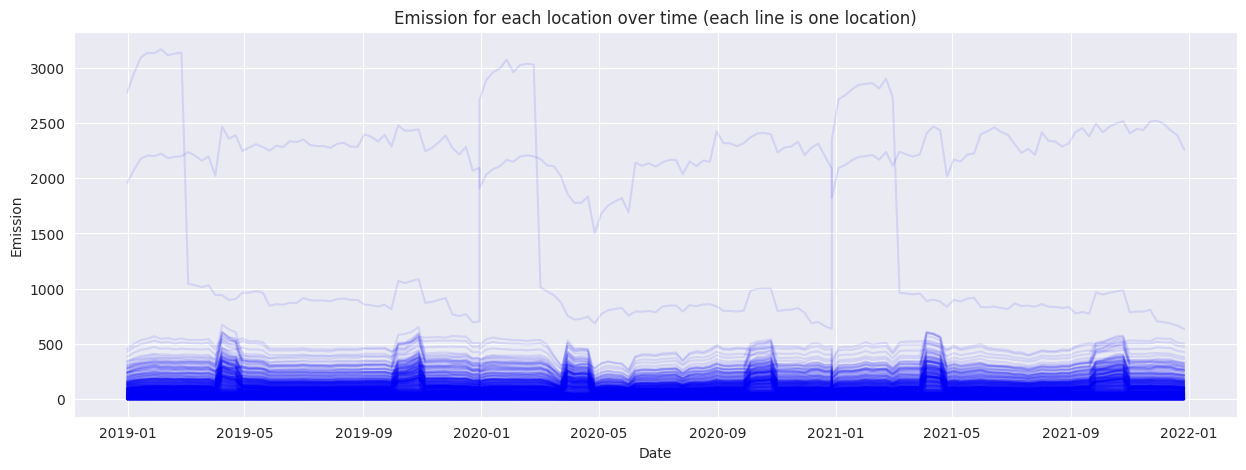

In [111]:
# get unique locations
unique_locations = emission_data[['latitude', 'longitude']].drop_duplicates()

# get it in list of tuples
unique_locations = [tuple(x) for x in unique_locations.values]


fig, ax = plt.subplots(figsize=(15, 5))

# for each unique location, plot its emission
for lat, lon in unique_locations:
    plot_data = emission_data[(emission_data['latitude'] == lat) & (emission_data['longitude'] == lon)]
    ax.plot(plot_data['week_date'], plot_data['emission'], label='emission', alpha=0.1, color='blue')

ax.set_title('Emission for each location over time (each line is one location)')
ax.set_xlabel('Date')
ax.set_ylabel('Emission')
plt.show()

We can see that we have two distinct locations at the top of the chart - we can see them on our scattermap too

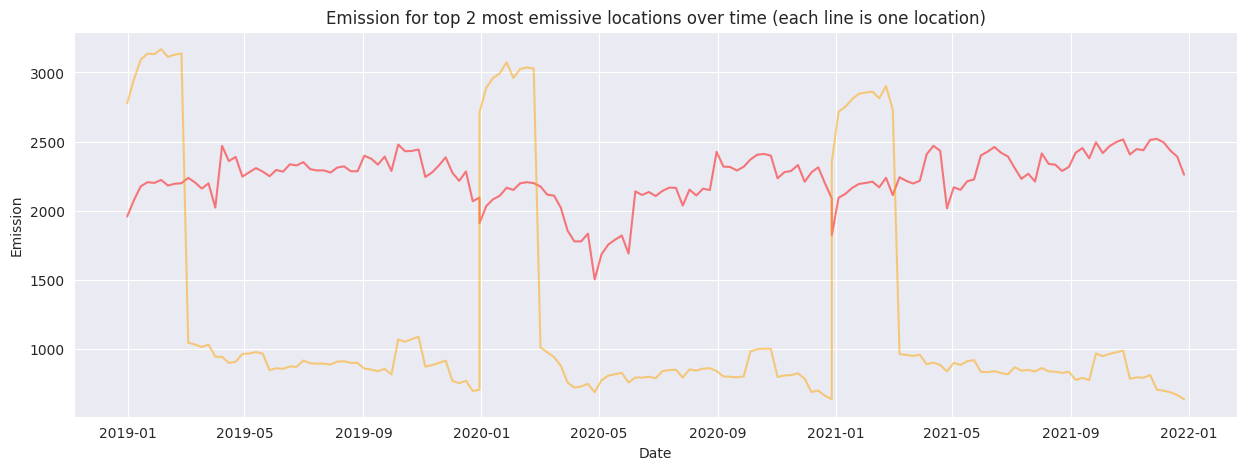

In [112]:
top_2_locations = emission_data.groupby(['latitude', 'longitude']).mean().sort_values(by='emission', ascending=False).head(2).index

fig, ax = plt.subplots(figsize=(15, 5))

lat1, lon1 = top_2_locations[0]
lat2, lon2 = top_2_locations[1]

plot_data1 = emission_data[(emission_data['latitude'] == lat1) & (emission_data['longitude'] == lon1)]
plot_data2 = emission_data[(emission_data['latitude'] == lat2) & (emission_data['longitude'] == lon2)]

ax.plot(plot_data1['week_date'], plot_data1['emission'], label='Top 1st location by emissions', alpha=0.5, color='red')
ax.plot(plot_data2['week_date'], plot_data2['emission'], label='Top 2nd location by emissions', alpha=0.5, color='orange')

ax.set_title('Emission for top 2 most emissive locations over time (each line is one location)')
ax.set_xlabel('Date')
ax.set_ylabel('Emission')
plt.show()

In [113]:
plot_data2['emission'].min()

635.9441

Let's zoom in previous chart on emission values below 600

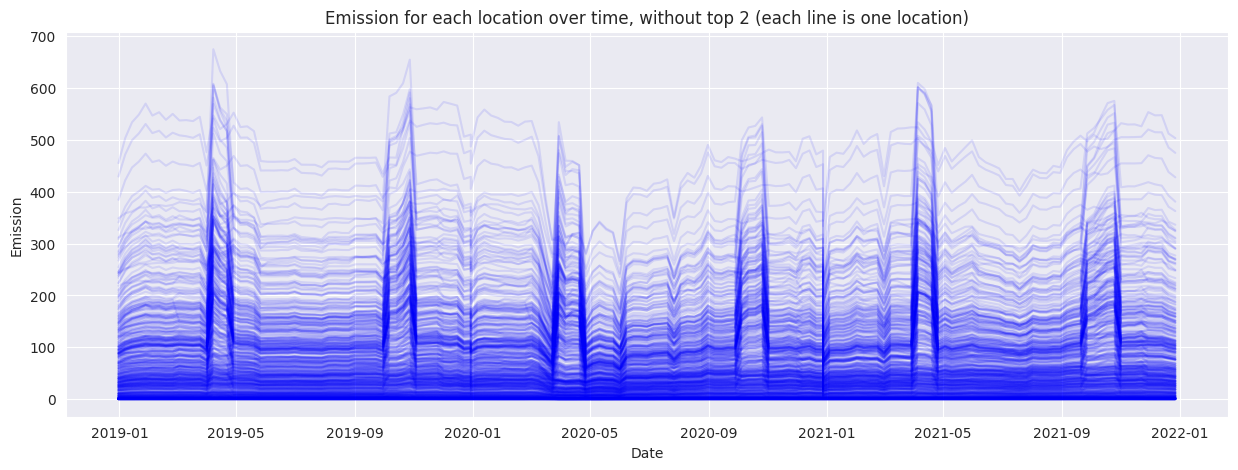

In [114]:
top_locations = [(lat1, lon1), (lat2, lon2)]

# get unique locations
unique_locations = emission_data[['latitude', 'longitude']].drop_duplicates()

# get it in list of tuples
unique_locations = [tuple(x) for x in unique_locations.values]

# remove top_locations from unique_locations
unique_locations = [x for x in unique_locations if x not in top_locations]

fig, ax = plt.subplots(figsize=(15, 5))

# for each unique location, plot its emission
for lat, lon in unique_locations:
    plot_data = emission_data[(emission_data['latitude'] == lat) & (emission_data['longitude'] == lon)]
    ax.plot(plot_data['week_date'], plot_data['emission'], label='emission', alpha=0.1, color='blue')

ax.set_title('Emission for each location over time, without top 2 (each line is one location)')
ax.set_xlabel('Date')
ax.set_ylabel('Emission')
plt.show()

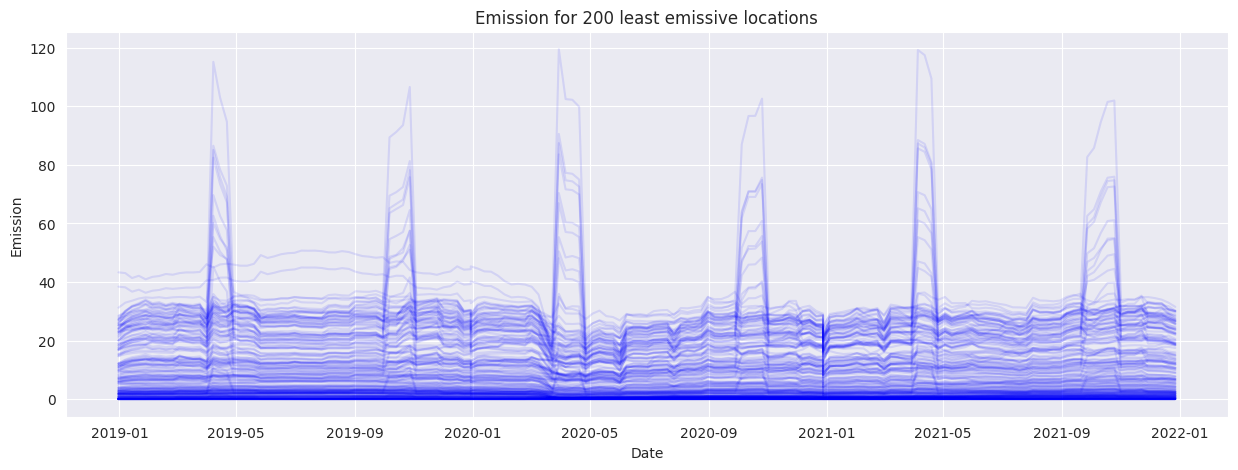

In [115]:
# select locations where median emission is below 200

least_emissive_locations = emission_data.groupby(['latitude', 'longitude'])['emission'].median().sort_values().index[:200]

# get it in list of tuples
unique_locations = [tuple(x) for x in least_emissive_locations.values]

fig, ax = plt.subplots(figsize=(15, 5))

# for each unique location, plot its emission
for lat, lon in unique_locations:
    plot_data = emission_data[(emission_data['latitude'] == lat) & (emission_data['longitude'] == lon)]
    ax.plot(plot_data['week_date'], plot_data['emission'], label='emission', alpha=0.1, color='blue')

ax.set_title('Emission for 200 least emissive locations')
ax.set_xlabel('Date')
ax.set_ylabel('Emission')
plt.show()

AmbrosM summarised it well here : https://www.kaggle.com/competitions/playground-series-s3e20/discussion/429278

Instead of predicting a time series for each location, it is sufficient to predict 5 basis ones as the rest follows (mostly the smallest ones are the same)

# Impute missing values

In [116]:
# we must impute missing values because xgboost can't handle them

# calculate means for all columns for each location
place_mean = df_train.groupby(['latitude', 'longitude']).mean()

# impute missing values with mean of given latitude, longitude from place_mean
df_train_imputed = df_train.groupby(['latitude', 'longitude']).transform(lambda x: x.fillna(x.mean()))
df_train_imputed['latitude'] = df_train['latitude']
df_train_imputed['longitude'] = df_train['longitude']

In [117]:
# original
df_train

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,-0.510,29.290,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,-0.510,29.290,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,-0.510,29.290,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,-0.510,29.290,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,...,5459.185355,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,29.404171
79019,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,...,5606.449457,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,29.186497
79020,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,NaN,...,6222.646776,56596.027209,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,29.131205
79021,-3.299,30.301,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,32.599393,...,7896.456885,46533.348194,6946.858022,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868,28.125792


In [118]:
df_train_imputed[['latitude','longitude','year','week_no','SulphurDioxide_SO2_column_number_density','SulphurDioxide_SO2_column_number_density_amf']]

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf
0,-0.510,29.290,2019,0,-0.000108,0.603019
1,-0.510,29.290,2019,1,0.000021,0.728214
2,-0.510,29.290,2019,2,0.000514,0.748199
3,-0.510,29.290,2019,3,0.000080,0.856283
4,-0.510,29.290,2019,4,-0.000079,0.676296
...,...,...,...,...,...,...
79018,-3.299,30.301,2021,48,0.000284,1.195643
79019,-3.299,30.301,2021,49,0.000083,1.130868
79020,-3.299,30.301,2021,50,0.000003,0.944682
79021,-3.299,30.301,2021,51,-0.000034,0.879397


In [119]:
# check if there are any missing values

df_train_imputed.isnull().sum()

year                                                0
week_no                                             0
SulphurDioxide_SO2_column_number_density          477
SulphurDioxide_SO2_column_number_density_amf      477
SulphurDioxide_SO2_slant_column_number_density    477
                                                 ... 
Cloud_solar_azimuth_angle                         477
Cloud_solar_zenith_angle                          477
emission                                            0
latitude                                            0
longitude                                           0
Length: 75, dtype: int64

Observation: yes, there are - which is important since it indicates that <b>for certain locations, particular columns are always empty</b>. 

We can probably take them from closest non-missing locations as approximations, but we will deal with it later.

# Feature importance

[15:19:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

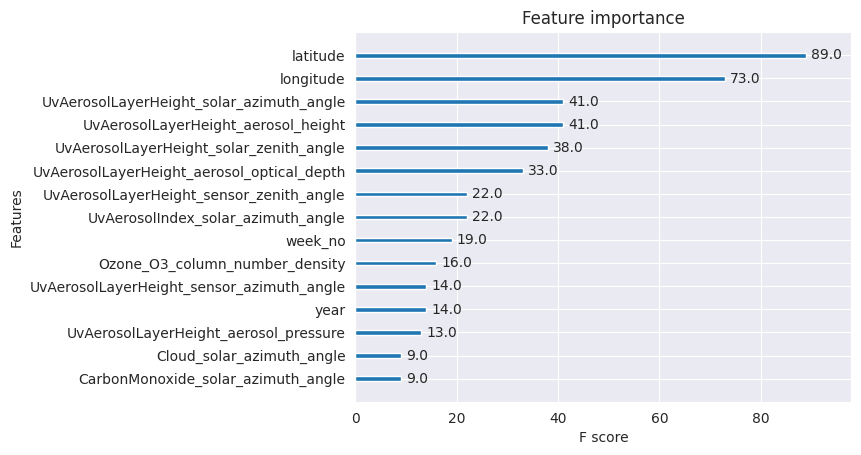

In [120]:
import xgboost as xgb

# since there are still rows with missing values, we will not use them for now

# drop rows with missing values
df_train_1 = df_train_imputed.dropna()

X = df_train_1[features]
y = df_train_1[target]

dtrain = xgb.DMatrix(X, label=y)

params = { 'silent': 1, 'objective': 'reg:squarederror' }
dmodel = xgb.train(params, dtrain, num_boost_round=10)

# see feature importance
xgb.plot_importance(dmodel, max_num_features=30)

Idea: feature importance might be different for each location

# Baseline model

We train our pre-baseline model - we don't drop rows because we want to be able to compare how much better is one method over the other on the same set of data.

We also want to split our fold with respect to time - we will create a new column 'datetime' from year and week_no.

In [121]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import get_scorer
from sklearn.pipeline import make_pipeline


params = {"objective":"reg:squarederror", "max_depth":3}
model = xgb.XGBRegressor(**params)

pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    model
)

# we split the data into train and test sets based on year - 2019, 2020 is train, 2021 is test
def split_data(df):
    train = df[df['year'] < 2021]
    test = df[df['year'] == 2021]
    return train, test

train, test = split_data(df_train_imputed)

X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# calculate rmse
rmse_train = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
rmse_validation = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE train: %f" % (rmse_train))
print("RMSE: %f" % (rmse))

RMSE train: 38.462577
RMSE: 88.869047


In [131]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import get_scorer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

params = {"objective":"reg:squarederror", "max_depth":10}
xgboost_model = xgb.XGBRegressor(**params)

models = {
    "XGBoost": xgboost_model,
    "LinearRegression": LinearRegression(n_jobs=-1),
    "SGDRegressor": SGDRegressor(),
    "RandomForestRegressor": RandomForestRegressor(n_jobs=-1),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(n_jobs=-1)
}

for name, model in models.items():
    pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        model
    )

    # we split the data into train and test sets based on year - 2019, 2020 is train, 2021 is test
    def split_data(df):
        train = df[df['year'] < 2021]
        test = df[df['year'] == 2021]
        return train, test

    train, test = split_data(df_train_imputed)

    X_train = train.drop(columns=[target])
    y_train = train[target]

    X_test = test.drop(columns=[target])
    y_test = test[target]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # calculate rmse
    rmse_train = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    rmse_validation = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{name} model with median imputation")
    print("RMSE train: %f" % (rmse_train))
    print("RMSE: %f" % (rmse_validation))

XGBoost model with median imputation
RMSE train: 28.395086
RMSE: 37.716579
LinearRegression model with median imputation
RMSE train: 140.287576
RMSE: 146.086716
SGDRegressor model with median imputation
RMSE train: 590517306292634517504.000000
RMSE: 590891058771014582272.000000
RandomForestRegressor model with median imputation
RMSE train: 7.512797
RMSE: 30.230963
DecisionTreeRegressor model with median imputation
RMSE train: 0.000000
RMSE: 40.940829
KNeighborsRegressor model with median imputation
RMSE train: 122.722471
RMSE: 152.603549


From first glance RandomForestRegressor. DecisionTreeRegressor and xgboost regressor are the best models currently. RMSE to beat: 30.23 based on data from 2021. 

I have displayed train RMSE to see if the model is able to overfit on the data at all. For now, let's just train on all of train data and submit first prediction.

# First submission

In [152]:
def impute_missing_values(df):
    # calculate means for all columns for each location
    place_mean = df.groupby(['latitude', 'longitude']).mean()

    # impute missing values with mean of given latitude, longitude from place_mean
    df_imputed = df.groupby(['latitude', 'longitude']).transform(lambda x: x.fillna(x.mean()))
    df_imputed['latitude'] = df['latitude']
    df_imputed['longitude'] = df['longitude'] 
    return df_imputed

def feature_engineering(df):
    df = impute_missing_values(df)
    return df

def train_model(model, raw_df, features, target):
    X_train = feature_engineering(raw_df[features])
    y_train = raw_df[target]
    model.fit(X_train, y_train)
    return model

def get_predictions(model, raw_df, features):
    original_df = raw_df.copy()
    X_test = feature_engineering(raw_df[features])
    original_df[target] = model.predict(X_test)
    return original_df

def save_submission(df):
    df[[id_columns, target]].to_csv("submission.csv", index=False)

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

id_columns = "ID_LAT_LON_YEAR_WEEK"
RANDOM_SEED = 128

target = "emission"
features = list(df_test.columns)
features.remove(id_columns)


pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=2000, random_state=RANDOM_SEED, n_jobs=-1)
)

model = train_model(pipeline, df_train, features, target)

output_test_df = get_predictions(model, df_test, features)
save_submission(output_test_df)

In [153]:
output_test_df[target].describe()

count    24353.000000
mean       103.460717
std        137.208454
min          0.000000
25%         26.906397
50%         72.081915
75%        153.211213
max       2441.866613
Name: emission, dtype: float64

Great, emissions are not negative :)

In [154]:
! kaggle competitions submit -c playground-series-s3e20 -f submission.csv -m "First submission"

100%|███████████████████████████████████████| 0.99M/0.99M [00:01<00:00, 692kB/s]
Successfully submitted to Predict CO2 Emissions in Rwanda